In [129]:
from pyspark import SparkContext
import datetime
import re
from scipy import sparse as sp
from pyspark.mllib.feature import Normalizer

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
sc = SparkContext("local[2]", "Movielens dataset")

24/02/04 16:14:23 WARN Utils: Your hostname, Sahasras-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.206 instead (on interface en0)
24/02/04 16:14:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/04 16:14:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Read user file -> Cols:  user id | age | gender | occupation | zip code
user_data = sc.textFile("./data/ml-100k/u.user")

In [5]:
# Dsiplays first element of RDD
user_data.first()

'1|24|M|technician|85711'

In [6]:
user_data.take(3)

['1|24|M|technician|85711', '2|53|F|other|94043', '3|23|M|writer|32067']

In [7]:
user_fields = user_data.map(lambda line: line.split("|"))
user_fields.take(2)

[['1', '24', 'M', 'technician', '85711'], ['2', '53', 'F', 'other', '94043']]

In [8]:
# Count the number of user_ids
num_users = user_fields.map(lambda fields: fields[0]).count()
num_users

943

In [9]:
num_genders = user_fields.map(lambda fields: fields[2]).distinct().count()
num_genders

2

In [10]:
num_zipcodes = user_fields.map(lambda fields: fields[4]).distinct().count()
num_zipcodes

795

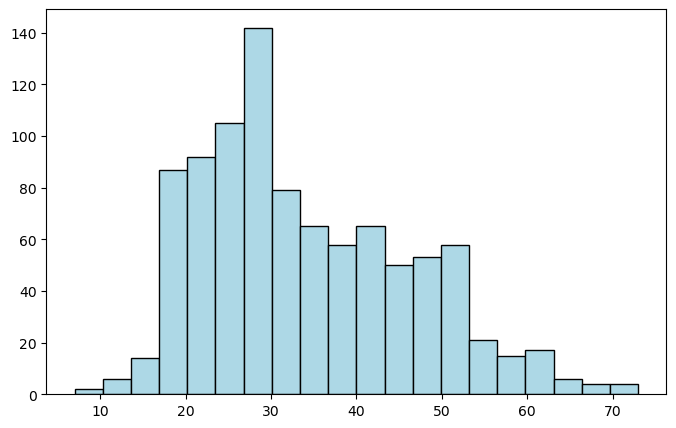

In [11]:
ages = user_fields.map(lambda x: int(x[1])).collect()
hist(ages, bins=20, color='lightblue', edgecolor='black')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 5)

In [12]:
# Chained transformations
count_by_occupation = user_fields.map(lambda fields: (fields[3], 1)).reduceByKey(lambda x, y: x+y).collect()
count_by_occupation

[('other', 105),
 ('writer', 45),
 ('executive', 32),
 ('lawyer', 12),
 ('educator', 95),
 ('entertainment', 18),
 ('homemaker', 7),
 ('artist', 28),
 ('marketing', 26),
 ('none', 9),
 ('retired', 14),
 ('doctor', 7),
 ('technician', 27),
 ('administrator', 79),
 ('student', 196),
 ('scientist', 31),
 ('programmer', 66),
 ('librarian', 51),
 ('engineer', 67),
 ('healthcare', 16),
 ('salesman', 12)]

In [13]:
x_axis1 = np.array([c[0] for c in count_by_occupation])
y_axis1 = np.array([c[1] for c in count_by_occupation])
x_axis1, y_axis1

(array(['other', 'writer', 'executive', 'lawyer', 'educator',
        'entertainment', 'homemaker', 'artist', 'marketing', 'none',
        'retired', 'doctor', 'technician', 'administrator', 'student',
        'scientist', 'programmer', 'librarian', 'engineer', 'healthcare',
        'salesman'], dtype='<U13'),
 array([105,  45,  32,  12,  95,  18,   7,  28,  26,   9,  14,   7,  27,
         79, 196,  31,  66,  51,  67,  16,  12]))

In [14]:
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]
x_axis, y_axis

(array(['doctor', 'homemaker', 'none', 'salesman', 'lawyer', 'retired',
        'healthcare', 'entertainment', 'marketing', 'technician', 'artist',
        'scientist', 'executive', 'writer', 'librarian', 'programmer',
        'engineer', 'administrator', 'educator', 'other', 'student'],
       dtype='<U13'),
 array([  7,   7,   9,  12,  12,  14,  16,  18,  26,  27,  28,  31,  32,
         45,  51,  66,  67,  79,  95, 105, 196]))

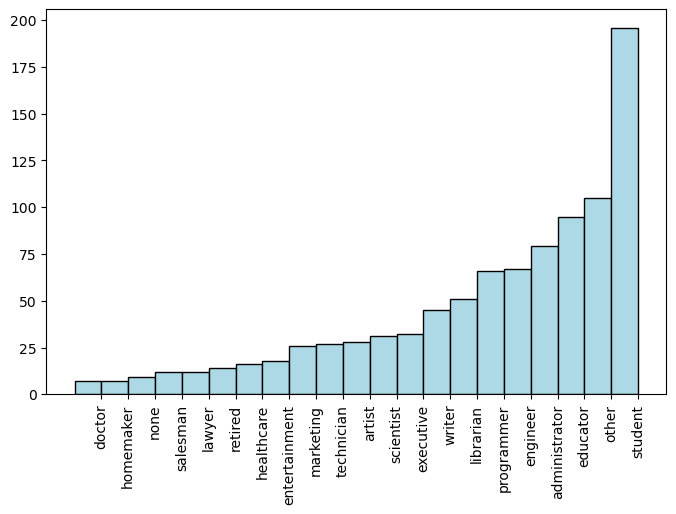

In [15]:
pos = np.arange(len(x_axis))
width = 1.0
ax = plt.axes()
ax.set_xticks(pos + (width/2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis, width, color='lightblue', edgecolor='black')
plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 5)

In [16]:
# Map Reduce method
count_by_occupation_ = user_fields.map(lambda fields: fields[3]).countByValue()
count_by_occupation_

defaultdict(int,
            {'technician': 27,
             'other': 105,
             'writer': 45,
             'executive': 32,
             'administrator': 79,
             'student': 196,
             'lawyer': 12,
             'educator': 95,
             'scientist': 31,
             'entertainment': 18,
             'programmer': 66,
             'librarian': 51,
             'homemaker': 7,
             'artist': 28,
             'engineer': 67,
             'marketing': 26,
             'none': 9,
             'healthcare': 16,
             'retired': 14,
             'salesman': 12,
             'doctor': 7})

In [17]:
movie_data = sc.textFile("./data/ml-100k/u.item")
movie_data.first()

'1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0'

In [18]:
movie_data.take(3), movie_data.count()

(['1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0',
  '2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0',
  '3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0'],
 1682)

In [19]:
def convert_year(x):
    try:
        return int(x[-4:])
    except:
        return 1900

In [20]:
movie_fields = movie_data.map(lambda line: line.split("|"))
movie_fields.take(3)

[['1',
  'Toy Story (1995)',
  '01-Jan-1995',
  '',
  'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)',
  '0',
  '0',
  '0',
  '1',
  '1',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0'],
 ['2',
  'GoldenEye (1995)',
  '01-Jan-1995',
  '',
  'http://us.imdb.com/M/title-exact?GoldenEye%20(1995)',
  '0',
  '1',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0'],
 ['3',
  'Four Rooms (1995)',
  '01-Jan-1995',
  '',
  'http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0']]

In [21]:
years = movie_fields.map(lambda field: field[2]).map(lambda x: convert_year(x))
years.take(3)

[1995, 1995, 1995]

In [22]:
years_filtered = years.filter(lambda x: x!=1900)

In [23]:
movie_ages = years_filtered.map(lambda yr: 1998-yr).countByValue()

In [24]:
values = np.array(list(movie_ages.values()))
bins = np.array(list(movie_ages.keys()))

In [25]:
values_f = values[np.argsort(bins)]
bins_f = bins[np.argsort(bins)]

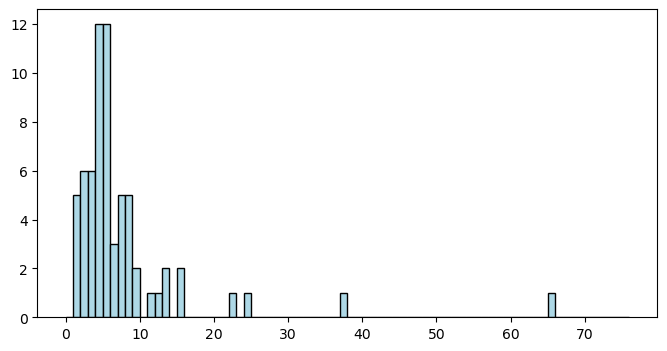

In [26]:
hist(values_f, bins=bins_f, color='lightblue', edgecolor='black')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 4)

In [27]:
rating_data_raw = sc.textFile("./data/ml-100k/u.data")
rating_data_raw.take(3)

['196\t242\t3\t881250949', '186\t302\t3\t891717742', '22\t377\t1\t878887116']

In [28]:
num_ratings = rating_data_raw.count()
num_ratings

100000

In [29]:
ratings_data = rating_data_raw.map(lambda line:line.split("\t"))
ratings_data.first()

['196', '242', '3', '881250949']

In [30]:
ratings = ratings_data.map(lambda field: int(field[2]))
max_rating = ratings.reduce(lambda x, y: max(x, y))  # np.max(ratings.collect())
min_rating = ratings.reduce(lambda x, y: min(x, y))
mean_rating = ratings.reduce(lambda x, y: x+y) / num_ratings
median_rating = np.median(ratings.collect())
ratings_per_user = num_ratings / num_users
ratings_per_movie = num_ratings / movie_data.count()
max_rating, min_rating, mean_rating, median_rating, ratings_per_user, ratings_per_movie

(5, 1, 3.52986, 4.0, 106.04453870625663, 59.45303210463734)

In [31]:
ratings.stats()

(count: 100000, mean: 3.5298600000000024, stdev: 1.125667970762251, max: 5.0, min: 1.0)

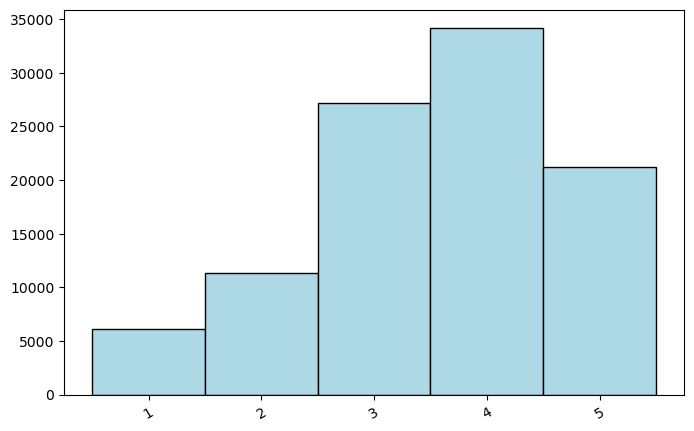

In [32]:
count_by_rating = ratings.countByValue()
count_by_rating_sorted = dict(sorted(count_by_rating.items()))
x_axis = np.array(list(count_by_rating_sorted.keys()))
y_axis = np.array(list(count_by_rating_sorted.values()))

pos = np.arange(1, len(x_axis)+1)
width = 1.0
ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(x_axis)

plt.bar(x_axis, y_axis, width, color='lightblue', edgecolor='black')
plt.xticks(rotation=30)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 5)

In [33]:
# Ratings per user, user and rating

user_ratings_grouped = ratings_data.map(lambda fields: (int(fields[0]), int(fields[2]))).groupByKey()
user_ratings_grouped.take(2)

[(196, <pyspark.resultiterable.ResultIterable at 0x11df89710>),
 (186, <pyspark.resultiterable.ResultIterable at 0x11dd3e410>)]

In [34]:
user_ratings_byuser = user_ratings_grouped.mapValues(len).sortByKey()
user_ratings_byuser.take(5)

[(1, 272), (2, 62), (3, 54), (4, 24), (5, 175)]

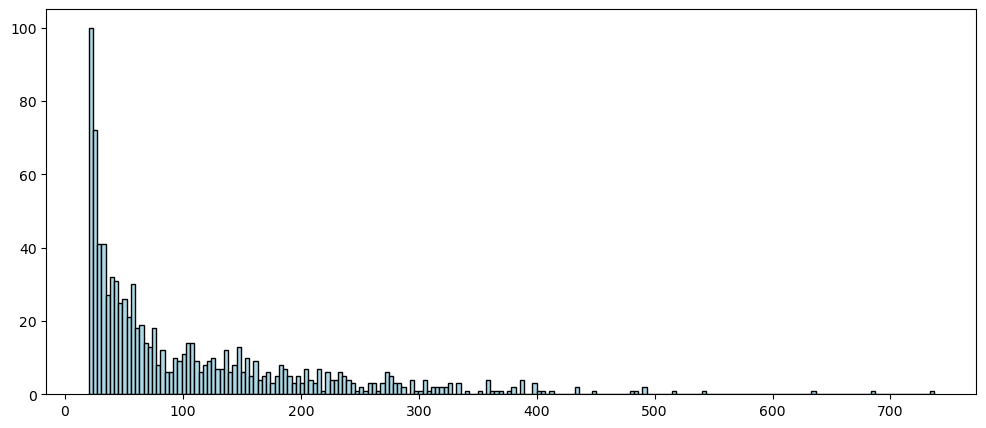

In [35]:
user_ratings_byuser_local = [v for (k, v) in user_ratings_byuser.collect()]
hist(user_ratings_byuser_local, bins=200, color='lightblue', edgecolor='black')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12,5)

In [36]:
ratings_data.take(2)

[['196', '242', '3', '881250949'], ['186', '302', '3', '891717742']]

In [37]:
# Rating per day - time series
# How to convert a timestamp in string format to datetime suitable format in pyspark

In [38]:
# Filter bad data
years_pre_processed = movie_fields.map(lambda x: x[2]).map(lambda y: convert_year(y)).collect()
years_pre_processed_arr = np.array(years_pre_processed)
years_pre_processed_arr

array([1995, 1995, 1995, ..., 1998, 1994, 1996])

In [39]:
mean_year = int(np.mean(years_pre_processed_arr[years_pre_processed_arr!=1900]))
median_year = int(np.median(years_pre_processed_arr[years_pre_processed_arr!=1900]))
mean_year, median_year

(1989, 1995)

In [40]:
index_bad_data = np.where(years_pre_processed_arr==1900)[0]
years_pre_processed_arr[index_bad_data] = median_year
# After filling bad value
np.where(years_pre_processed_arr == 1900)

(array([], dtype=int64),)

In [41]:
user_fields.take(2)

[['1', '24', 'M', 'technician', '85711'], ['2', '53', 'F', 'other', '94043']]

In [42]:
all_occupations = user_fields.map(lambda x: x[3]).distinct().collect()
all_occupations.sort()

In [43]:
# Creating dictionary of all occupations
idx = 0
all_occupations_dict = {}

for occ in all_occupations:
    all_occupations_dict[occ] = idx
    idx+=1
    
all_occupations_dict

{'administrator': 0,
 'artist': 1,
 'doctor': 2,
 'educator': 3,
 'engineer': 4,
 'entertainment': 5,
 'executive': 6,
 'healthcare': 7,
 'homemaker': 8,
 'lawyer': 9,
 'librarian': 10,
 'marketing': 11,
 'none': 12,
 'other': 13,
 'programmer': 14,
 'retired': 15,
 'salesman': 16,
 'scientist': 17,
 'student': 18,
 'technician': 19,
 'writer': 20}

In [44]:
k = len(all_occupations_dict)
binary_x = np.zeros(k)

k_programmer = all_occupations_dict['programmer']
binary_x[k_programmer] = 1
# One hot encoded representation of 'programmer'
binary_x

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0.])

In [45]:
def extract_datetime(ts):
    return datetime.datetime.fromtimestamp(ts)

In [46]:
timestamps = ratings_data.map(lambda x: int(x[3]))
hour_of_day = timestamps.map(lambda x: extract_datetime(x).hour)
hour_of_day.take(5)

[10, 14, 2, 0, 0]

In [47]:
def assign_tod(hr):
    times_of_day = {
        'morning': range(7, 12),
        'lunch': range(12, 14),
        'afternoon': range(14, 18),
        'evening': range(18, 23),
        'night': [0, 1, 2, 3, 4, 5, 6]
        
    }
    for k, v in times_of_day.items():
        if hr in v:
            return k

In [48]:
time_of_day = hour_of_day.map(lambda hr: assign_tod(hr))
time_of_day.take(5)

['morning', 'afternoon', 'night', 'night', 'night']

In [49]:
movie_fields.take(1)

[['1',
  'Toy Story (1995)',
  '01-Jan-1995',
  '',
  'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)',
  '0',
  '0',
  '0',
  '1',
  '1',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0']]

In [50]:
def extract_title(title):
    grps = re.search("\((\w+)\)", title)
    if grps:
        return title[:grps.start()].strip()
    else:
        return title

In [51]:
raw_titles = movie_fields.map(lambda x: x[1])

for raw_title in raw_titles.take(5):
    print(extract_title(raw_title))

Toy Story
GoldenEye
Four Rooms
Get Shorty
Copycat


In [52]:
movie_titles = raw_titles.map(lambda x: extract_title(x))
title_terms = movie_titles.map(lambda t: t.split(" "))
title_terms.take(5)

[['Toy', 'Story'],
 ['GoldenEye'],
 ['Four', 'Rooms'],
 ['Get', 'Shorty'],
 ['Copycat']]

In [60]:
all_terms = title_terms.flatMap(lambda x: x).distinct().collect()

idx = 0
all_terms_dict = {}

for term in all_terms:
    all_terms_dict[term] = idx
    idx+=1

In [62]:
print("Total terms: {}\nIndex of term 'Dead': {}".format(len(all_terms_dict), all_terms_dict['Dead']))

Total terms: 2645
Index of term 'Dead': 9


In [66]:
all_index_dict_zip = title_terms.flatMap(lambda x: x).distinct().zipWithIndex().collectAsMap()

In [97]:
title_terms.take(10)

[['Toy', 'Story'],
 ['GoldenEye'],
 ['Four', 'Rooms'],
 ['Get', 'Shorty'],
 ['Copycat'],
 ['Shanghai', 'Triad', '(Yao', 'a', 'yao', 'yao', 'dao', 'waipo', 'qiao)'],
 ['Twelve', 'Monkeys'],
 ['Babe'],
 ['Dead', 'Man', 'Walking'],
 ['Richard', 'III']]

In [119]:
def create_sparse_vector(terms, term_dict):
    num_terms = len(term_dict)
    x = sp.csc_matrix((1, num_terms))

    for t in terms:
        if t in term_dict:
            idx = term_dict[t]
            x[0, idx] = 1
    return x

In [120]:
title_terms.take(2)

[['Toy', 'Story'], ['GoldenEye']]

In [123]:
all_terms_bcast = sc.broadcast(all_terms_dict)
term_vectors = title_terms.map(lambda terms: create_sparse_vector(terms, all_terms_bcast.value))
term_vectors.take(5)

[<1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>]

In [128]:
# E.g of normalizing a feature vector
np.random.seed(42)

x = np.random.randn(10)
norm_x = np.linalg.norm(x)

normalized_x = x/norm_x
print("x is: {}\n2-Norm of x is: {}\nNormalized x: {}\n2-Norm of normalized x: {}".format(x, norm_x, normalized_x, np.linalg.norm(normalized_x)))

x is: [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x is: 2.5908023950696855
Normalized x: [ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized x: 1.0


In [131]:
normalizer = Normalizer()
vector = sc.parallelize([x])
normalized_x_mllib = normalizer.transform(vector).first().toArray()

In [132]:
print("x is: {}\n2-Norm of x is: {}\nNormalized x: {}\n2-Norm of normalized x: {}".format(x, norm_x, normalized_x_mllib, np.linalg.norm(normalized_x_mllib)))

x is: [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x is: 2.5908023950696855
Normalized x: [ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized x: 1.0
